In [25]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [26]:
# Path to the JSONL file
WORDs = [
    "Acknowledgement",
    "Subdermatoglyphic",
    "tHyUiKaRbNqWeOpXcZvM",
]
GPT4Outputs = [
    "./jsonl/Acknowledgement-batch_XbhrSOcSB5EuAalvaf6pPnwp_output.jsonl",
    "./jsonl/Subdermatoglyphic-batch_KsEDCtqcuiLUd0fctyVDLeuJ_output.jsonl",
    "./jsonl/tHyUiKaRbNqWeOpXcZvM-batch_zSapvpcg51piGdd3wDSRqoGH_output.jsonl",
]

index = 2
WORD = WORDs[index]
file_path = GPT4Outputs[index]

gt_data = pd.read_json(f"./images/{WORD}/configurations.json")

In [27]:
# Dictionary to map custom_id to message content
custom_id_to_content = {}

# Open the file and read line by line
with open(file_path, "r") as file:
    for line in file:
        json_obj = json.loads(line)
        # Extract custom_id and message content
        custom_id = json_obj.get("custom_id")
        message_content = json_obj["response"]["body"]["choices"][0]["message"][
            "content"
        ]
        # Map custom_id to message content
        if custom_id:
            custom_id_to_content[custom_id] = message_content

# Print the dictionary to verify
print(len(custom_id_to_content))

478


In [28]:
# let's reformat keys, split with "uid__" and keep the last part
custom_id_to_content = {
    key.split("uid__")[-1]: value for key, value in custom_id_to_content.items()
}

# for the values, let's geet the text inside " and " ) and ignore if there is no "
custom_id_to_content = {
    key: value.split('"')[1] if '"' in value else value
    for key, value in custom_id_to_content.items()
}

# rmemove . and turn lower case and if the reaming
custom_id_to_content = {
    key: value.lower().replace(".", "").strip()
    for key, value in custom_id_to_content.items()
}

# remove items with value longer than 1
custom_id_to_content = {
    key: value for key, value in custom_id_to_content.items() if len(value) == 1
}


# Convert the dictionary to a DataFrame
custom_id_df = pd.DataFrame(
    list(custom_id_to_content.items()), columns=["image_path", "predicted"]
)

# Merge with gt_data on the image_path column
combined_data = pd.merge(gt_data, custom_id_df, on="image_path", how="inner")

# Remove rows where the 'predicted' column has missing values
cleaned_data = combined_data.dropna(subset=["predicted"])
cleaned_data["gt"] = cleaned_data.apply(
    lambda row: row["word"][row["circle_index"]].lower(), axis=1
)

# Display the combined DataFrame
cleaned_data

,word,font_path,circle_index,thickness,scale_factor,padding,x_offset,y_offset,canvas_width,canvas_height,final_width,final_height,image_path,predicted,gt
0,tHyUiKaRbNqWeOpXcZvM,fonts/Helvetica.ttf,0,4,1.4,25,0,0,10,2,512,512,./images/tHyUiKaRbNqWeOpXcZvM/text_image_a3822...,t,t
1,tHyUiKaRbNqWeOpXcZvM,fonts/Helvetica.ttf,0,4,1.4,50,0,0,10,2,512,512,./images/tHyUiKaRbNqWeOpXcZvM/text_image_9168d...,t,t
2,tHyUiKaRbNqWeOpXcZvM,fonts/Helvetica.ttf,0,4,1.4,100,0,0,10,2,512,512,./images/tHyUiKaRbNqWeOpXcZvM/text_image_eb1fb...,t,t
3,tHyUiKaRbNqWeOpXcZvM,fonts/Helvetica.ttf,0,4,1.4,200,0,0,10,2,512,512,./images/tHyUiKaRbNqWeOpXcZvM/text_image_56d82...,t,t
4,tHyUiKaRbNqWeOpXcZvM,fonts/Helvetica.ttf,0,5,1.4,25,0,0,10,2,512,512,./images/tHyUiKaRbNqWeOpXcZvM/text_image_a2300...,t,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,tHyUiKaRbNqWeOpXcZvM,"fonts/OpenSans-VariableFont_wdth,wght.ttf",19,5,1.4,200,0,0,10,2,512,512,./images/tHyUiKaRbNqWeOpXcZvM/text_image_42f35...,m,m
471,tHyUiKaRbNqWeOpXcZvM,"fonts/OpenSans-VariableFont_wdth,wght.ttf",19,6,1.4,25,0,0,10,2,512,512,./images/tHyUiKaRbNqWeOpXcZvM/text_image_1418c...,m,m
472,tHyUiKaRbNqWeOpXcZvM,"fonts/OpenSans-VariableFont_wdth,wght.ttf",19,6,1.4,50,0,0,10,2,512,512,./images/tHyUiKaRbNqWeOpXcZvM/text_image_8e326...,m,m
473,tHyUiKaRbNqWeOpXcZvM,"fonts/OpenSans-VariableFont_wdth,wght.ttf",19,6,1.4,100,0,0,10,2,512,512,./images/tHyUiKaRbNqWeOpXcZvM/text_image_94466...,m,m


In [29]:
cleaned_data["is_prediction_correct"] = cleaned_data["gt"] == cleaned_data["predicted"]
# get accuracy
accuracy = cleaned_data["is_prediction_correct"].mean()
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Overall Accuracy: 78.95%


In [30]:
errors = cleaned_data[cleaned_data["is_prediction_correct"] == False]
common_errors = (
    errors.groupby(["predicted", "gt"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
)
print(common_errors.head(10))

   predicted gt  count
18         u  i     21
11         o  p     20
17         r  b     11
14         o  x      9
13         o  v      7
4          h  y      5
9          o  c      5
20         z  v      3
1          a  k      2
19         w  e      2


/var/folders/y1/b5wjnkp96_b7cvzncx0zsry40000gn/T/ipykernel_78972/24165238.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/y1/b5wjnkp96_b7cvzncx0zsry40000gn/T/ipykernel_78972/24165238.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/y1/b5wjnkp96_b7cvzncx0zsry40000gn/T/ipykernel_78972/24165238.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 1].set_xticklabels(list("Subdermatoglyphic"))
/var/folders/y1/b5wjnkp96_b7cvzncx0zsry40000gn/T/ipykernel_78972/24165238.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in 

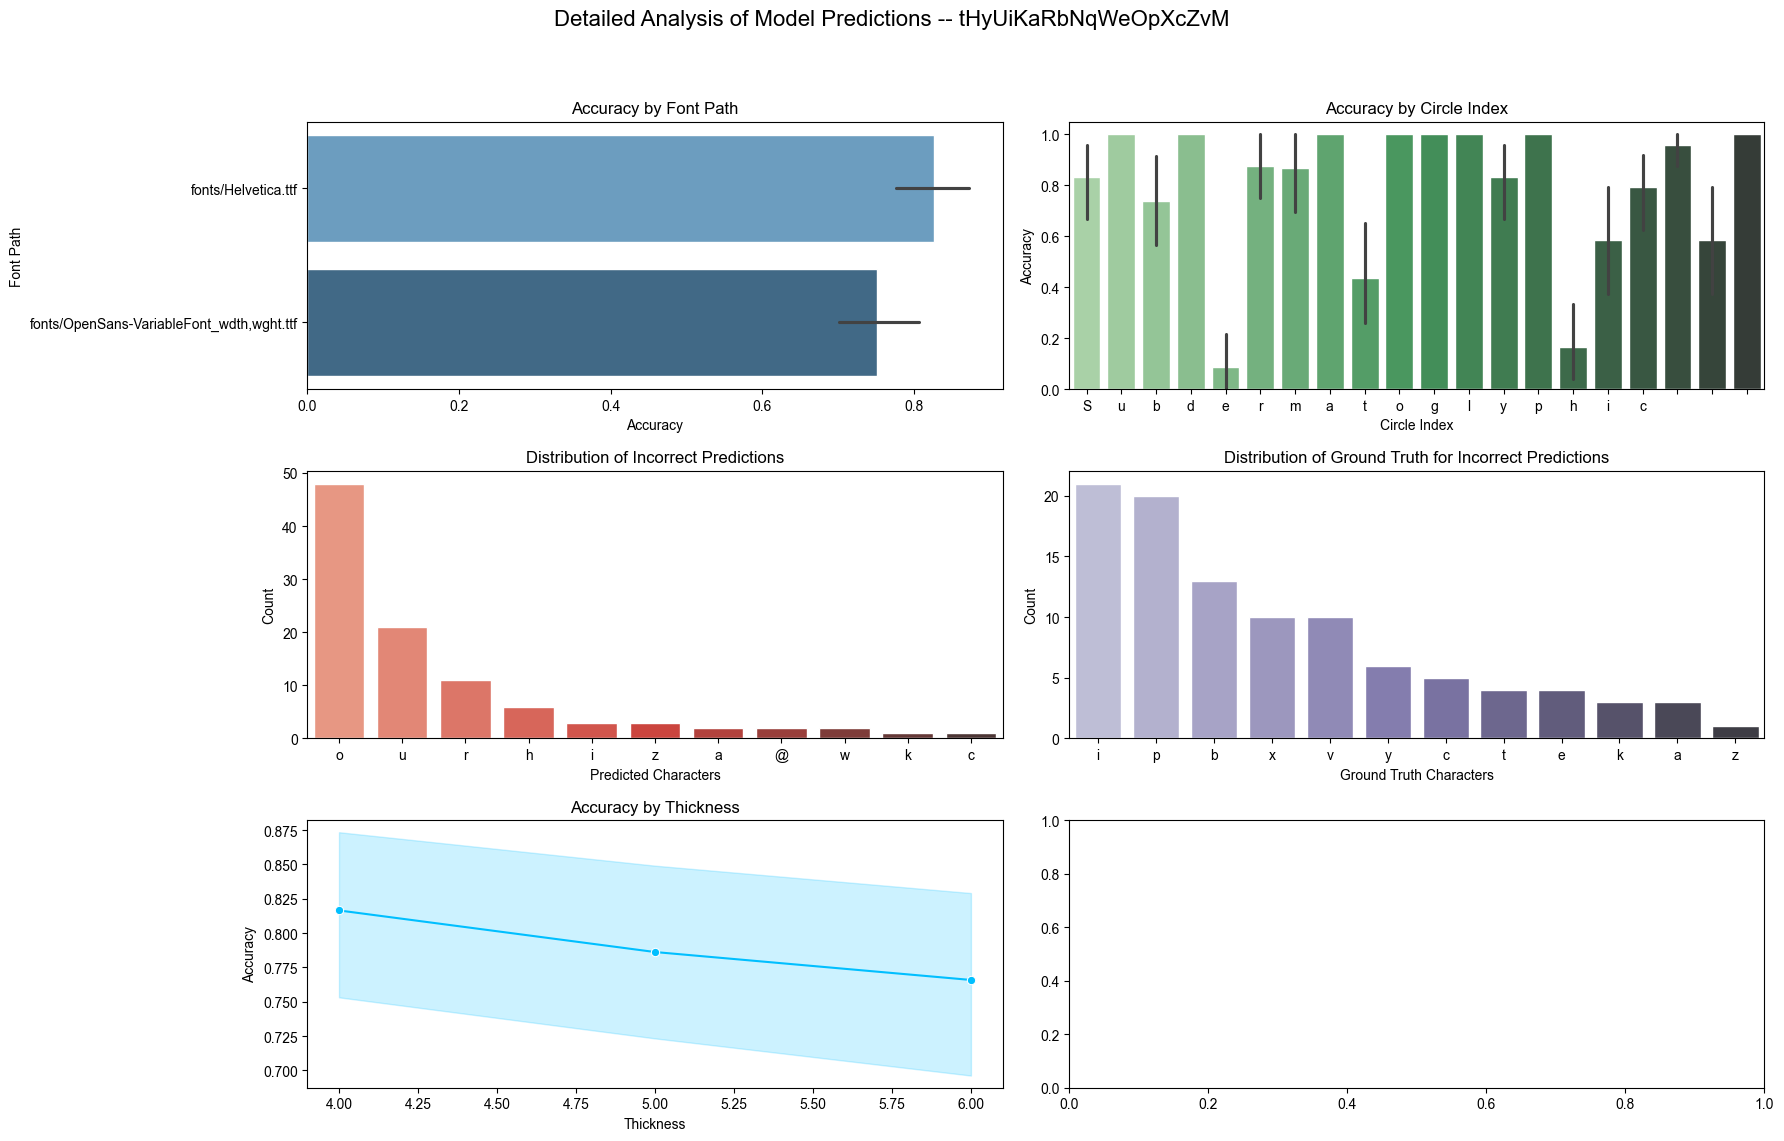

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure with a more professional color palette and layout
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))
fig.suptitle(f"Detailed Analysis of Model Predictions -- {WORD}", fontsize=16)

# Customize the color palette
sns.set(style="whitegrid", palette="muted")

# Plot Accuracy by Font Path
sns.barplot(
    ax=axes[0, 0],
    x="is_prediction_correct",
    y="font_path",
    data=cleaned_data,
    estimator=lambda x: x.mean(),
    palette="Blues_d",
)
axes[0, 0].set_title("Accuracy by Font Path")
axes[0, 0].set_xlabel("Accuracy")
axes[0, 0].set_ylabel("Font Path")

# Plot Accuracy by Circle Index
sns.barplot(
    ax=axes[0, 1],
    x="circle_index",
    y="is_prediction_correct",
    data=cleaned_data,
    estimator=lambda x: x.mean(),
    palette="Greens_d",
)
axes[0, 1].set_title("Accuracy by Circle Index")
axes[0, 1].set_xlabel("Circle Index")
axes[0, 1].set_ylabel("Accuracy")
# Set x-axis labels to characters from the word
axes[0, 1].set_xticklabels(list("Subdermatoglyphic"))


# Plot Distribution of Incorrect Predictions
sns.countplot(
    ax=axes[1, 0],
    x="predicted",
    data=errors,
    order=errors["predicted"].value_counts().index,
    palette="Reds_d",
)
axes[1, 0].set_title("Distribution of Incorrect Predictions")
axes[1, 0].set_xlabel("Predicted Characters")
axes[1, 0].set_ylabel("Count")

# Plot Distribution of Ground Truth for Incorrect Predictions
sns.countplot(
    ax=axes[1, 1],
    x="gt",
    data=errors,
    order=errors["gt"].value_counts().index,
    palette="Purples_d",
)
axes[1, 1].set_title("Distribution of Ground Truth for Incorrect Predictions")
axes[1, 1].set_xlabel("Ground Truth Characters")
axes[1, 1].set_ylabel("Count")

# Plot Accuracy by Thickness
sns.lineplot(
    ax=axes[2, 0],
    x="thickness",
    y="is_prediction_correct",
    data=cleaned_data,
    estimator=lambda x: x.mean(),
    marker="o",
    color="deepskyblue",
)
axes[2, 0].set_title("Accuracy by Thickness")
axes[2, 0].set_xlabel("Thickness")
axes[2, 0].set_ylabel("Accuracy")


plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust subplots to fit into figure area.
plt.show()

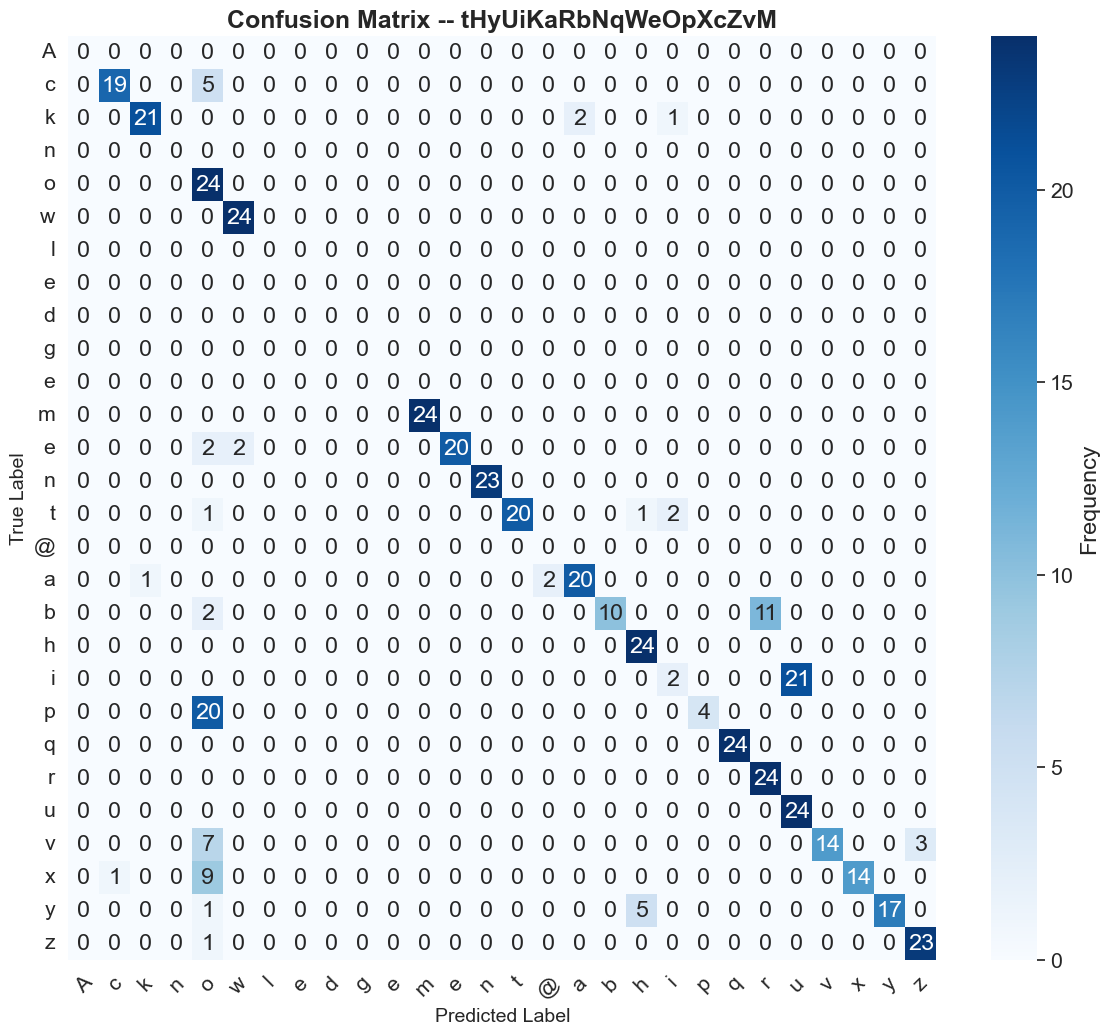

In [32]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Extract ground truth and predictions
ground_truth = cleaned_data["gt"]
predictions = cleaned_data["predicted"]

# Define the order of labels based on the word "Acknowledgement" and any extra characters
desired_order = list(
    "Acknowledgement"
)  # Ensure it's in lowercase if your data is in lowercase
all_labels = np.unique(np.concatenate((ground_truth, predictions)))
extra_labels = [label for label in all_labels if label not in desired_order]
final_labels = desired_order + extra_labels

# Create the confusion matrix with the specified label order
conf_matrix = confusion_matrix(ground_truth, predictions, labels=final_labels)

# Plot the confusion matrix with a more professional appearance
plt.figure(figsize=(14, 12))
sns.set(font_scale=1.4)  # Increase font size for readability
heatmap = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=final_labels,
    yticklabels=final_labels,
    cbar_kws={"label": "Frequency"},
)
plt.title(f"Confusion Matrix -- {WORD}", fontsize=18, fontweight="bold")
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

# Export

In [37]:
import pandas as pd
import json

# Define the words and their corresponding JSONL file paths
WORDs = [
    "Acknowledgement",
    "Subdermatoglyphic",
    "tHyUiKaRbNqWeOpXcZvM",
]
GPT4Outputs = [
    "./jsonl/Acknowledgement-batch_XbhrSOcSB5EuAalvaf6pPnwp_output.jsonl",
    "./jsonl/Subdermatoglyphic-batch_KsEDCtqcuiLUd0fctyVDLeuJ_output.jsonl",
    "./jsonl/tHyUiKaRbNqWeOpXcZvM-batch_zSapvpcg51piGdd3wDSRqoGH_output.jsonl",
]

# Initialize an empty list to store DataFrames
all_data_frames = []
missing_files = {}

# Loop through each word and its corresponding file
for index, WORD in enumerate(WORDs):
    file_path = GPT4Outputs[index]
    gt_data = pd.read_json(f"./images/{WORD}/configurations.json")
    custom_id_to_content = {}

    gt_data["fnames"] = gt_data["image_path"].apply(lambda x: x.split("/")[-1])
    expected_files = set(list(gt_data["fnames"]))

    # Read the JSONL file and extract data
    with open(file_path, "r") as file:
        for line in file:
            json_obj = json.loads(line)
            custom_id = json_obj.get("custom_id")
            message_content = json_obj["response"]["body"]["choices"][0]["message"][
                "content"
            ]
            if custom_id:
                custom_id_to_content[custom_id] = message_content
            else:
                print(f"WARNING: Custom id is None for {line}")

    print(f"size of custom_id_to_content: {len(custom_id_to_content)}")

    custom_id_to_content_original = custom_id_to_content.copy()
    custom_id_to_content_original = {
        key.split("uid__")[-1]: value
        for key, value in custom_id_to_content_original.items()
    }
    # Process the extracted data
    custom_id_to_content = {
        key.split("uid__")[-1]: value.split('"')[1] if '"' in value else value
        for key, value in custom_id_to_content.items()
    }
    custom_id_to_content = {
        key: value.lower().replace(".", "").strip()
        for key, value in custom_id_to_content.items()
    }

    print(f"size of custom_id_to_content: {len(custom_id_to_content)}")

    custom_id_to_content = {
        key: value for key, value in custom_id_to_content.items() if len(value) == 1
    }

    print(f"size of custom_id_to_content: {len(custom_id_to_content)}")
    print(
        f"size of custom_id_to_content_original: {len(custom_id_to_content_original)}"
    )

    # Convert to DataFrame and merge
    custom_id_df = pd.DataFrame(
        list(custom_id_to_content.items()), columns=["image_path", "predicted"]
    )
    combined_data = pd.merge(gt_data, custom_id_df, on="image_path", how="inner")
    combined_data["gt"] = combined_data.apply(
        lambda row: row["word"][row["circle_index"]].lower(), axis=1
    )
    combined_data["word_label"] = WORD  # Add a column to identify the word

    # add custom_id_to_content_original as model-output-raw
    combined_data["model-output-raw"] = combined_data["image_path"].map(
        custom_id_to_content_original
    )

    # Append to the list
    all_data_frames.append(combined_data)
    # check for missing files
    combined_data["fname"] = combined_data["image_path"].apply(
        lambda x: x.split("/")[-1]
    )
    missing_files[WORD] = set(expected_files) - set(list(combined_data["fnames"]))
    print(f"Missing files: {missing_files}")

# Concatenate all DataFrames into one
final_data_frame = pd.concat(all_data_frames, ignore_index=True)

size of custom_id_to_content: 360
size of custom_id_to_content: 360
size of custom_id_to_content: 360
size of custom_id_to_content_original: 360
Missing files: {'Acknowledgement': set()}
size of custom_id_to_content: 408
size of custom_id_to_content: 408
size of custom_id_to_content: 408
size of custom_id_to_content_original: 408
Missing files: {'Acknowledgement': set(), 'Subdermatoglyphic': set()}
size of custom_id_to_content: 480
size of custom_id_to_content: 480
size of custom_id_to_content: 480
size of custom_id_to_content_original: 480
Missing files: {'Acknowledgement': set(), 'Subdermatoglyphic': set(), 'tHyUiKaRbNqWeOpXcZvM': set()}


In [38]:
final_data_frame["Model"] = ["GPT-4o"] * len(final_data_frame)

In [39]:
final_data_frame.to_pickle("./data/gpt-4o.pkl")

In [40]:
# count per model and prompt
final_data_frame.groupby(["Model", "word"]).size()

Model   word                
GPT-4o  Acknowledgement         360
        Subdermatoglyphic       408
        tHyUiKaRbNqWeOpXcZvM    480
dtype: int64

In [41]:
len(final_data_frame)

1248